In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""Test reparam of curves that are not equivqalent """
import torch
from torch.utils.data import TensorDataset
torch.set_default_dtype(torch.float64)
import matplotlib.pyplot as plt
from deepthermal.FFNN_model import fit_FFNN, FFNN, init_xavier
from deepthermal.validation import create_subdictionary_iterator, k_fold_cv_grid

from deepthermal.plotting import plot_result, plot_model_1d

from deep_reparametrization.plotting import plot_reparametrization
from deep_reparametrization.reparametrization import (
    get_elastic_metric_loss,
    compute_loss_reparam,
    get_elastic_error_func,
)
from deep_reparametrization.ResNET import ResNET
import test.curves_2 as tc2

In [3]:
########
PATH_FIGURES = "../figures/curve_3"
########

SET_NAME = "16_curve_2_tanh"

FOLDS = 1
N =  256 # training points internal

MODEL_PARAMS = {
    "model": [ResNET],
    "input_dimension": [1],
    "output_dimension": [1],
    "n_hidden_layers": [5],
    "neurons": [20],
    "activation": ["relu"],
}
TRAINING_PARAMS = {
    "num_epochs": [1],
    "batch_size": [N],
    "regularization_param": [1e-9],
    "optimizer": ["strong_wolfe"],
    "learning_rate": [0.0001],
    "compute_loss": [compute_loss_reparam],
    "loss_func": [get_elastic_metric_loss(r = tc2.q, constrain_cost=5e3, verbose=False)],
}

In [4]:
# Load data
x_train = torch.linspace(0,1,N, requires_grad=True).unsqueeze(1)
y_train = tc2.r(x_train.detach())

x_val = torch.linspace(0, 1, N, requires_grad=True).unsqueeze(1)
y_val = tc2.r(x_val.detach())

data = TensorDataset(x_train, y_train)
data_val = TensorDataset(x_val, y_val)

model_params_iter = create_subdictionary_iterator(MODEL_PARAMS)
training_params_iter = create_subdictionary_iterator(TRAINING_PARAMS)

Do the actual training

In [5]:
cv_results = k_fold_cv_grid(
    model_params=model_params_iter,
    fit=fit_FFNN,
    training_params=training_params_iter,
    data=data,
    val_data=data_val,
    folds=FOLDS,
    verbose=True,
    get_error=get_elastic_error_func(r=tc2.q, true_dist=tc2.DIST_R_Q),
)


Running model (trial=0, mod=0, k=0):
################################  0  ################################
Training Loss:  0.8371708
Validation Loss:  0.8371708
Final Training Loss:  0.8371708
Final Validation Loss:  0.8371708


In [6]:
# plotting
x_train_ = x_train.detach()
x_sorted, indices = torch.sort(x_train_, dim=0)

plot_kwargs = {
    "x_test" : x_sorted,
    "y_train": x_sorted,
    "x_train": tc2.ksi(x_sorted),
    "x_axis": "t",
    "y_axis": "$\\xi(t)$",
}
plot_result(
    path_figures=PATH_FIGURES,
    plot_name=SET_NAME,
    **cv_results,
    plot_function=plot_model_1d,
    function_kwargs=plot_kwargs,
    trials=5
)

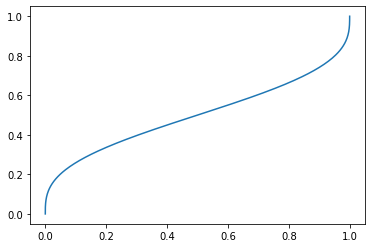

In [7]:
from torch.nn.functional import mse_loss
ksi_eval = tc2.ksi(x_val)
from torch import autograd
from torch.nn.functional import mse_loss

plt.plot(ksi_eval.detach(), x_val.detach() )
plt.show()
#
# dist_func= get_elastic_error_func(r=tc2.q, true_dist=tc2.DIST_R_Q)
# data_new= TensorDataset(x_val,tc2.q(x_val))
# dist = dist_func(model=tc2.ksi, data= data_new)
# dist.item()

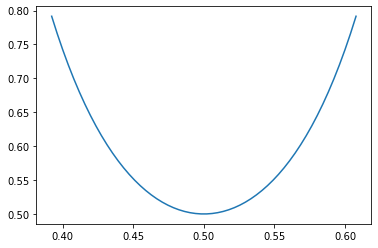

tensor([[       inf],
        [3.2174e+11],
        [5.0283e+09],
        [4.4157e+08],
        [7.8624e+07],
        [2.0622e+07],
        [6.9109e+06],
        [2.7428e+06],
        [1.2321e+06],
        [6.0838e+05],
        [3.2369e+05],
        [1.8295e+05],
        [1.0869e+05],
        [6.7343e+04],
        [4.3241e+04],
        [2.8634e+04],
        [1.9477e+04],
        [1.3565e+04],
        [9.6474e+03],
        [6.9904e+03]])

In [8]:
ksi_x = tc2.ksi(x_val)
ksi_ksi_x = tc2.ksi(ksi_x)
dksi_dksi_x = autograd.grad(ksi_ksi_x.sum(), ksi_x)[0]
dksi_inv_dx = 1/dksi_dksi_x
# mse_loss(tc2.r, tc2.q(ksi_x))
plt.plot(x_val.detach()[100:-100],1/dksi_dksi_x.detach()[100:-100])
# plt.plot(ksi_x[::10].detach(), torch.ones_like(ksi_ksi_x[::10]), "*")
plt.show()
1/dksi_dksi_x.detach()[:20]
